# Выбор локации для скважины

В ходе данного проекта проведем анализ добычи нефти в трех различных регионах для компании «ГлавРосГосНефть». Основной задачей будет определение того, где необходимо будет произвести бурение скважины. Используя данные для каждой из имеющихся скважин, мы создадим модель, которая позволит предсказать регион с максимальной возможной прибылью.  

В качестве исходных данных воспользуемся имеющимися датасетами для трех регионов. Структура датасетов следующая: 
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

В ходе создания модели загрузим и подготовим исходные данные о трех различных регионах, проверим данные на дубликаты, пропуски и аномальные значения. С помощью линейной регрессии обучим модель на предсказание целевого показателя (product). Это позволит также реализовать функцию по расчету предсказываемой прибыли. С помощью техники bootstrap расчитаем и проанализируем возможную прибыль.

In [35]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

In [36]:
#Определим основные переменные
#доход с 1 тыс. барелей 
INCOME_FROM_PRODUCT = 450*10**3

#бюджет, выделенный на добычу в одном регионе 
BUDGET_FOR_REGION = 10*10**9

#количество мест добычи 
NUMBER_OF_LOCATIONS = 200

#общее число мест для выборки 
TOTAL_NUMBER_OF_LOCATIONS = 500

# 1. Предобработка данных 

В ходе изучения наших данных исследуем представленные типы данных, пропуски и дубликаты значений, проанализируем исходные данные на взаимосвязанность. 

In [37]:
#Считываем csv файлы с данными и сохраняем их в соответсвующие датафреймы
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('geo_data_0.csv')  
    data_1 = pd.read_csv('geo_data_1.csv') 
    data_2 = pd.read_csv('geo_data_2.csv') 

In [38]:
#Поместим данные для всех регионов в один списко 
datas = [data_0, data_1, data_2]

Проанализируем общий вид данных для каждого региона. 

In [39]:
#Выведем первые 10 строчек из датафрейма
data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [40]:
data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [41]:
data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [42]:
#Выведем общую информацию о данных 
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [43]:
#Выведем общую информацию о данных 
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [44]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [45]:
print('Дубликатов в 0ом регионе -', data_0.duplicated().sum())
print('Дубликатов в 1ом регионе -',data_1.duplicated().sum())
print('Дубликатов в 2ем регионе -',data_2.duplicated().sum())

Дубликатов в 0ом регионе - 0
Дубликатов в 1ом регионе - 0
Дубликатов в 2ем регионе - 0


**Вывод**: данные не содержат пропущенных значений, их типы соответсвуют их смыслу и значениям, явные дубликаты отсутствуют. 

In [46]:
#Оценим взаимосвязь данных, исключив неимеющие для этой процедуры смысла признаки 
features = ['f0', 'f1', 'f2']
drop = ['id', 'product']
data_0.drop(drop, axis = 1).corr()

,f0,f1,f2
f0,1.000000,-0.440723,-0.003153
f1,-0.440723,1.000000,0.001724
f2,-0.003153,0.001724,1.000000


In [47]:
data_1.drop(drop, axis = 1).corr()

,f0,f1,f2
f0,1.000000,0.182287,-0.001777
f1,0.182287,1.000000,-0.002595
f2,-0.001777,-0.002595,1.000000


In [48]:
data_2.drop(drop, axis = 1).corr()

,f0,f1,f2
f0,1.000000,0.000528,-0.000448
f1,0.000528,1.000000,0.000779
f2,-0.000448,0.000779,1.000000


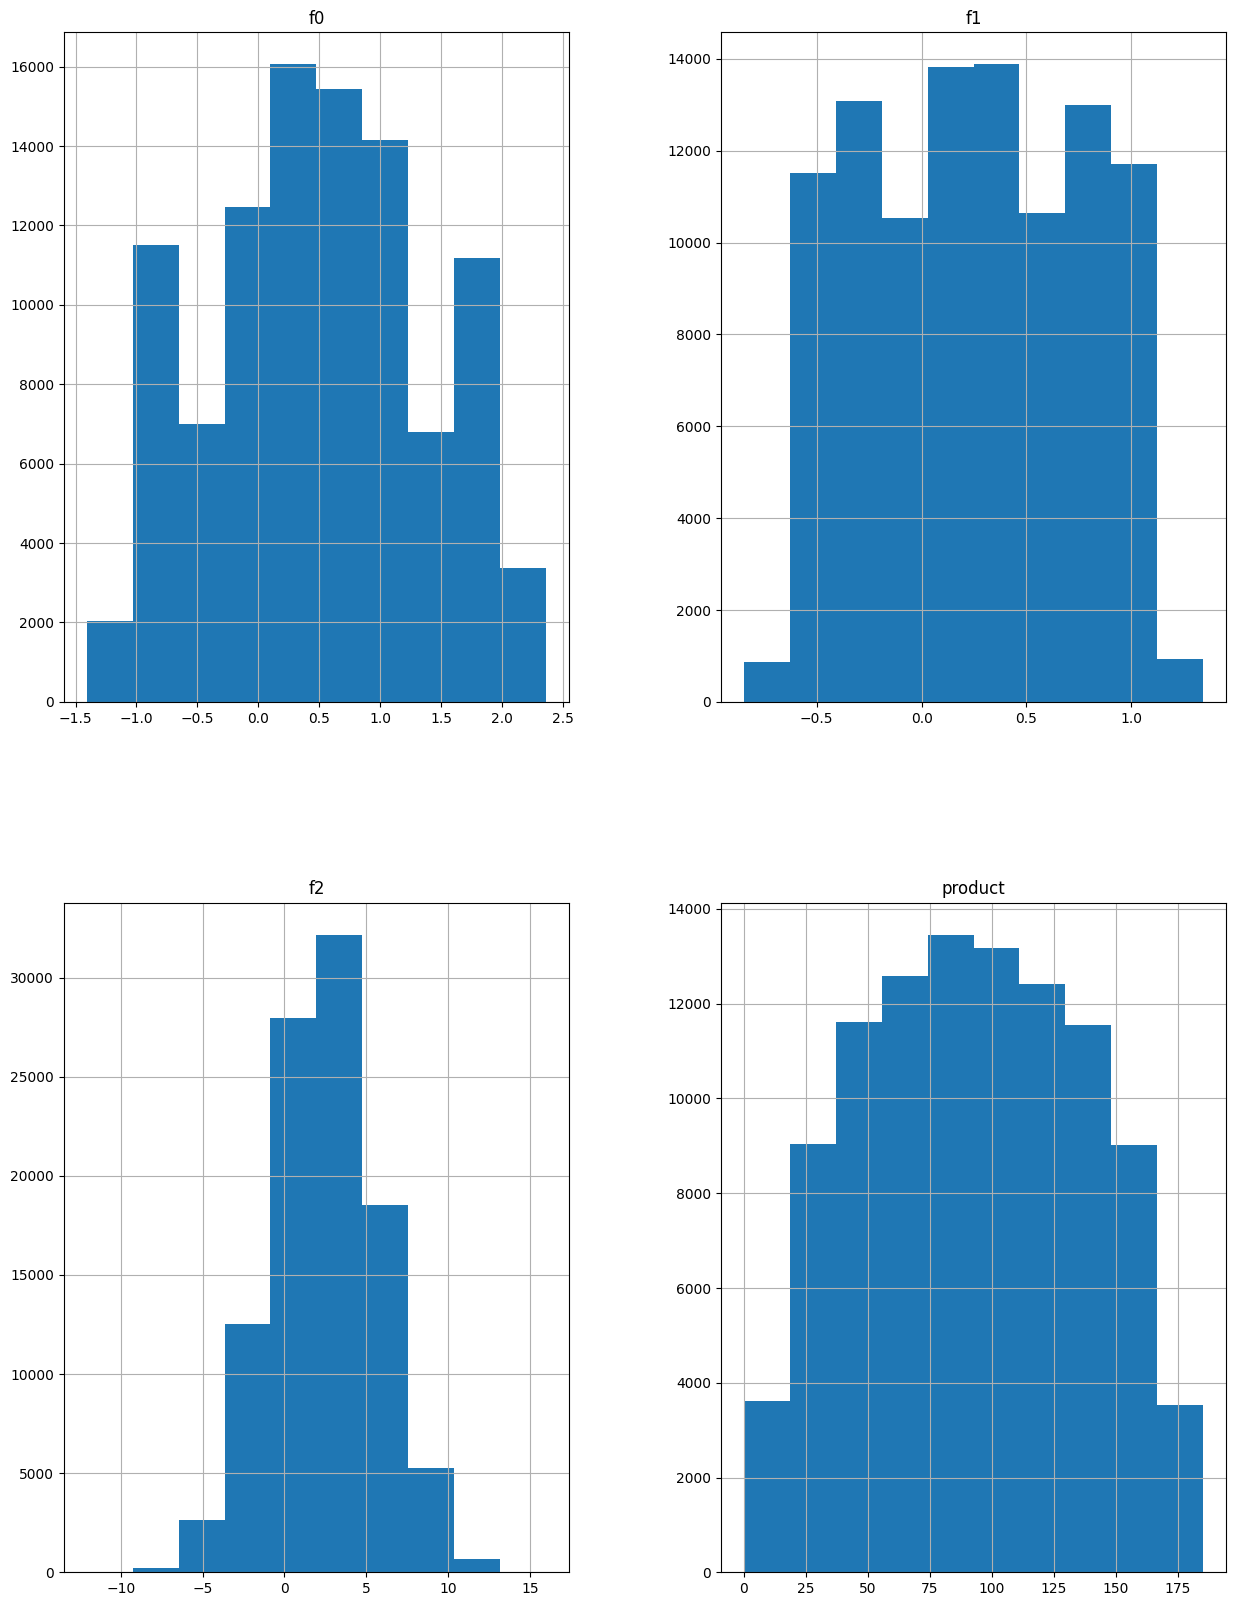

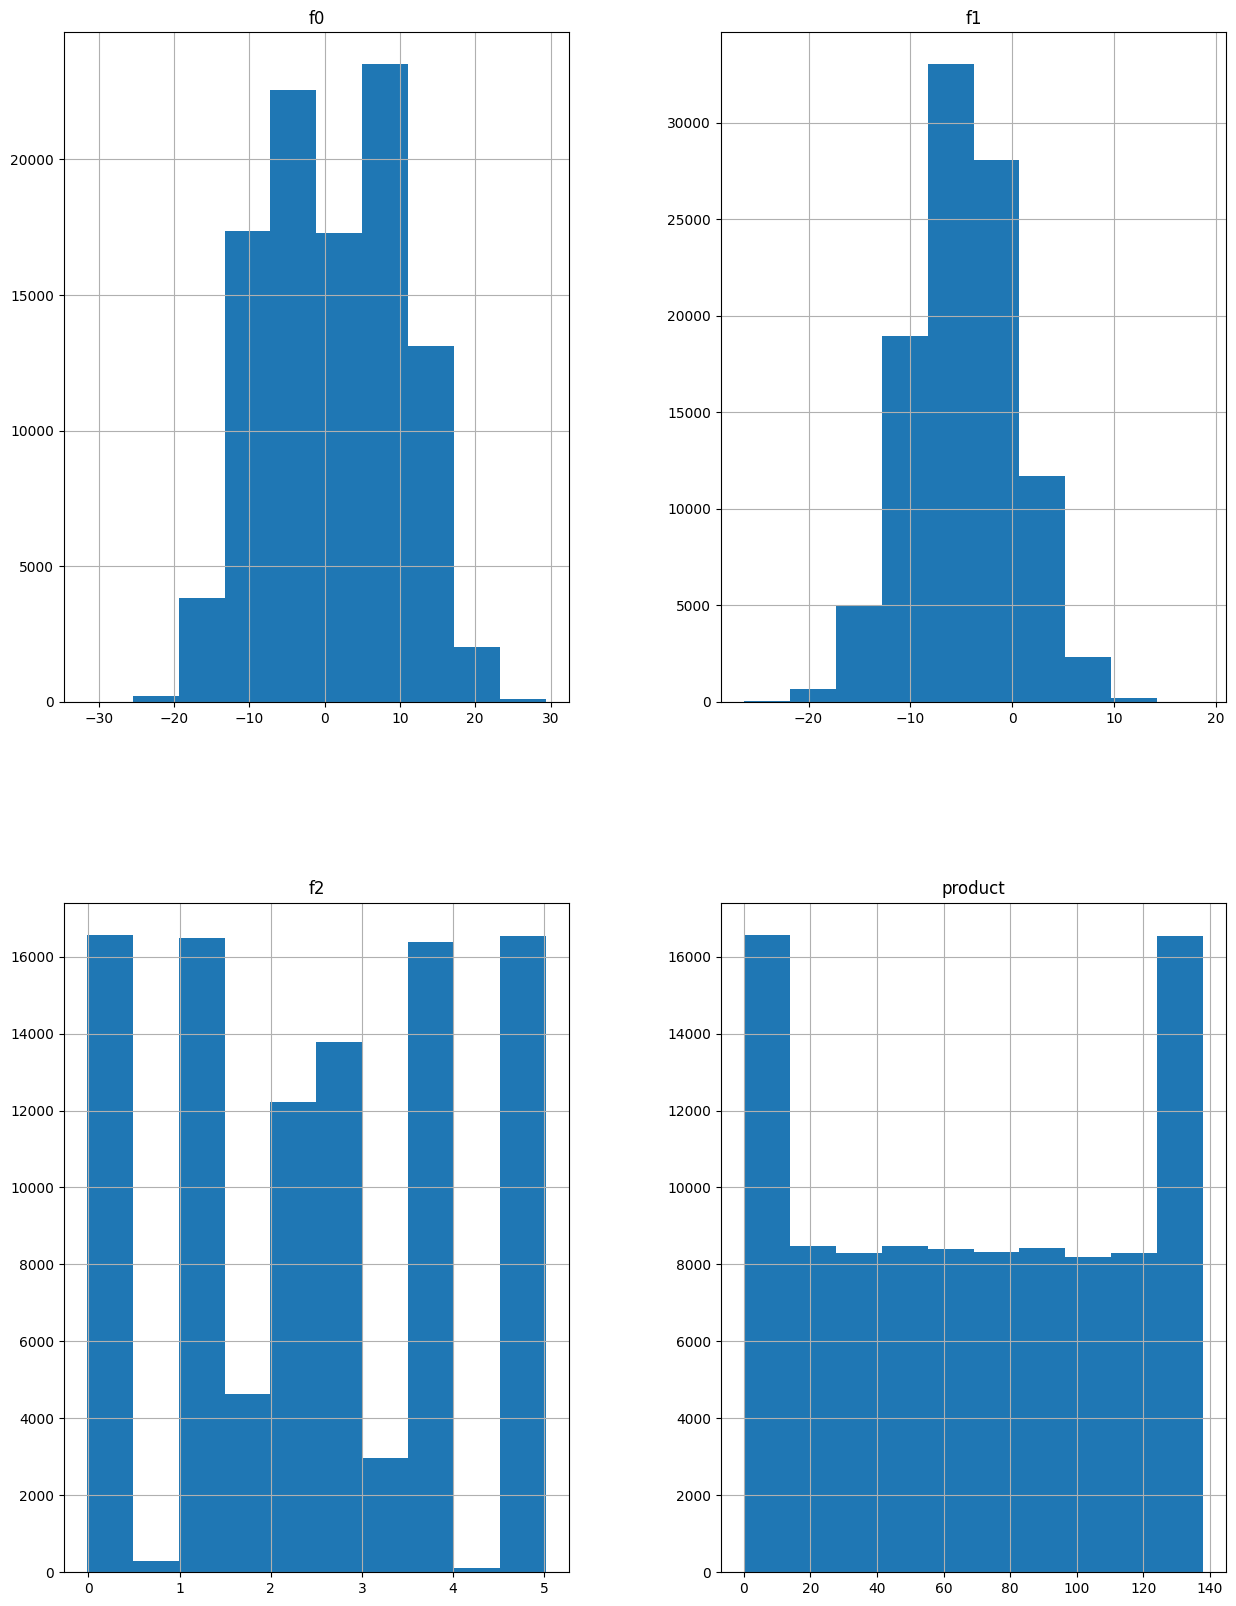

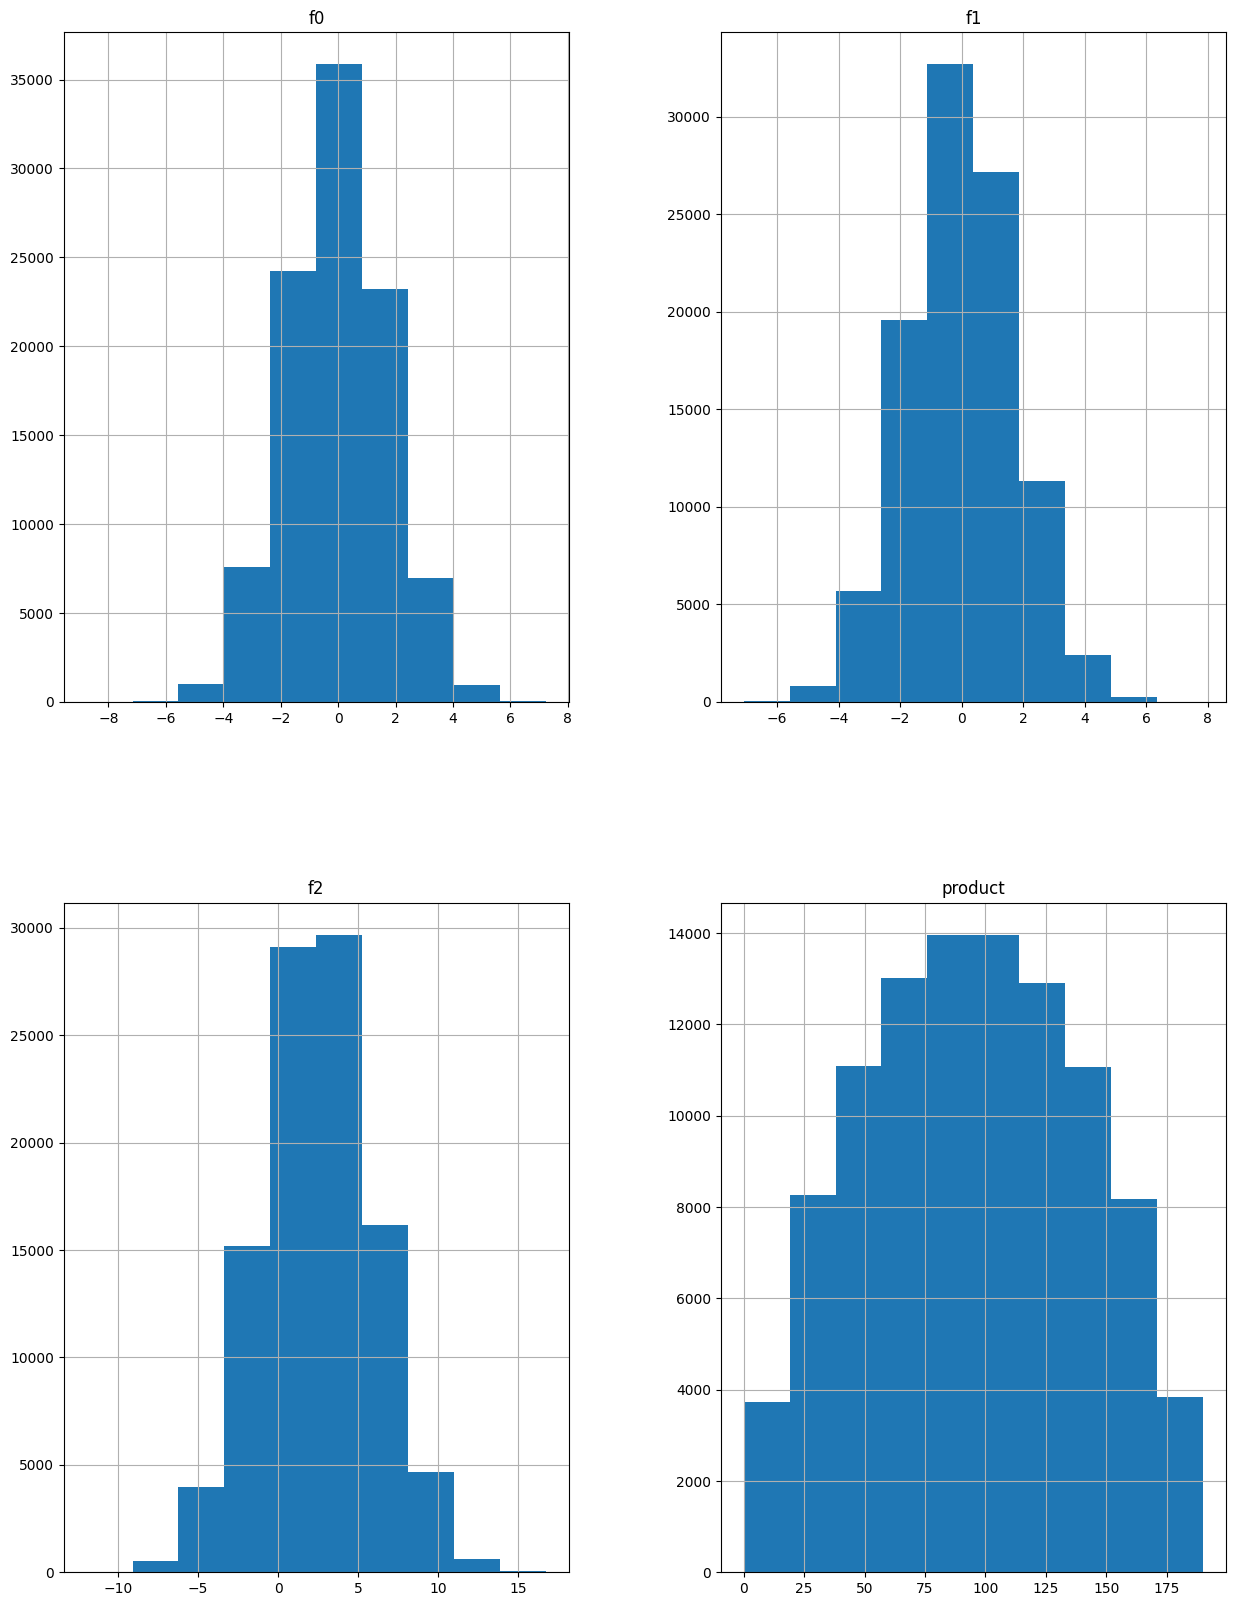

In [49]:
for i, data in enumerate(datas):
    data.hist(figsize=(15,20))

In [50]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [51]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [52]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Вывод**: изучены исходные данные для дальшнего построения модели. Не выявлено пропусков, дубликатов и аномальных значений. Для первого региона выявлена отрицательная корелляция между признаком f0 и f1. 

Определим наличие неявных дубликатов по столбцу 'id'. 

In [53]:
for i, data in enumerate(datas):
    print('Дубликаты по столбцу id в регионе', i, ' - ', len(data[data['id'].duplicated()]))

Дубликаты по столбцу id в регионе 0  -  10
Дубликаты по столбцу id в регионе 1  -  4
Дубликаты по столбцу id в регионе 2  -  4


**Вывод**: наличие подобных дубликатов говорит о том, что необходимо избавиться от неоднозначной информации. Поскольку мы не знаем какие из представленных данных более достоверные, то для корректности дальнейшей работы, уберем все мешающие данные.  

In [54]:
#Удаление дубликатов по id 
for data in datas:
    data['id'].drop_duplicates()

# 2. Модель предсказания запаса сырья 

Создадим модель предсказывающую запас сырья в каждом из представленных регионов. Для этого разобьем исходную выборку на обучающую и валидационную и примененим в качестве механизма предсказания **линейную регрессию**. 

In [55]:
#Проверим исходный размер выборок
for i, data in enumerate(datas):
    print(i,'-', data.shape)

0 - (100000, 5)
1 - (100000, 5)
2 - (100000, 5)


In [56]:
#Объединим для удобства все данные в списки 
target = []
features = [] 
features_train = []
features_valid = []
target_train = []
target_valid = []
for data in datas:
    target.append(data['product'])
    features.append(data.drop(['product', 'id'] , axis=1))

In [57]:
#Разделим каждую из трех исходных выборок на тренировочную и валидационную 
for i in range(len(datas)):
    features_train_i, features_valid_i, target_train_i, target_valid_i = train_test_split(
    features[i], target[i], test_size=0.25, random_state=12345)
    features_train.append(features_train_i)
    features_valid.append(features_valid_i)
    target_train.append(target_train_i)
    target_valid.append(target_valid_i)


In [58]:
#Проверим конечный размер выборок
print('Target Valid shapes')
for i, targ in enumerate(target_valid):
    print(i,'-', targ.shape)

Target Valid shapes
0 - (25000,)
1 - (25000,)
2 - (25000,)


In [59]:
#Проверим конечный размер выборок
print('Target train shapes')
for i, targ in enumerate(target_train):
    print(i,'-', targ.shape)

Target train shapes
0 - (75000,)
1 - (75000,)
2 - (75000,)


In [60]:
#Произведем моделирование с помощью линейной регрессии
model = []
predicted_valid = []
for i in range(len(datas)):
    model.append(LinearRegression())
    model[i].fit(features_train[i], target_train[i])
    predicted_valid.append(pd.Series(model[i].predict(features_valid[i])))
    mse = mean_squared_error(target_valid[i], predicted_valid[i])
    print('Для региона', i, 'RMSE =', mse**0.5 )
    print('Средний запас предсказанного сырья', predicted_valid[i].mean() )

Для региона 0 RMSE = 37.5794217150813
Средний запас предсказанного сырья 92.59256778438035
Для региона 1 RMSE = 0.8930992867756165
Средний запас предсказанного сырья 68.72854689544602
Для региона 2 RMSE = 40.02970873393434
Средний запас предсказанного сырья 94.96504596800489


**Вывод**: проведено моделирование для запасов сырья каждого из трех регионов с помощью линейной регрессии. Качество моделирования оценено с помощью параметра RMSE и достигает наилучшего значения для региона 1. 
Для предсказанных значений product расчитаны также средние значения и составляют:
- для 0 - **92.6** тыс. бар.
- для 1 - **68.7** тыс. бар. 
- для 2 - **94.9** тыс. бар.

Приведем данные к единому формату для дальнейших вычислений. 

In [61]:
for i, target in enumerate(target_valid):
    target_valid[i] = target_valid[i].reset_index(drop=True)
for predicted in predicted_valid:
    predicted = pd.Series(predicted)

# 3. Расчет прибыли 


Реализуем функцию для расчета прибыли по выбранным скважинам и предсказаниям созданной модели. 

In [62]:
min_number_of_products = (BUDGET_FOR_REGION/NUMBER_OF_LOCATIONS/INCOME_FROM_PRODUCT)
print ('Минимальное количество продукта для безубыточной добычи', min_number_of_products)

Минимальное количество продукта для безубыточной добычи 111.11111111111111


**Вывод**: минимальное необходимое количество продукта для безубыточной добычи превышает раннее найденые предсказанные значения средних запасов в каждом регионе.  

**Вывод**: полученные данные(средние значения и минимальное необходимое количство продукта) не позволяют сделать окончательные выводы о потенциале имеющихся регионов. Для дальнейшего анализа воспользуемся технологией бутстрапирования. Данный статистический метод позволит более полно проанализировать возможную прибыль с каждого региона.  В данном случае бутстрапирование  позволяет построить распределение вероятностей прибыли и рисков в регионе на основе имеющихся данных. Такой подход позволит получить более надежные оценки прибыли и рисков для осуществления бизнес плана в регионе. 

Для реализации функции выберем скважины с максимальным значением предсказаний, просуммируем **целевые значения** объема сырья, соответствующие этим предсказаниям и расчитаем прибыль с полученного объема.


# 4. Расчет средней прибыли, рисков и доверительных интервалов 

Используем технологию Bootstrap c 1000 выборок для подсчета средней прибыли с выбранных регионов 

In [64]:
#функция bootstrap подсчета средней прибыли
def income_bootstrap(target, predicted):
    state = RandomState(12345)
    values = []
    for i in range(1000):
        #сгенерированный список целевых значений размером 500
        target_subsample = target.sample(n = TOTAL_NUMBER_OF_LOCATIONS, replace=True, random_state=state)
        predicted_subsample = predicted[target_subsample.index]
        values.append(income_calculation(target_subsample, predicted_subsample))
    values = pd.Series(values)
    values_mean = int(values.mean())
    
    #расчет нижней и верхней границы доверительного интервала
    lower = int(values.quantile(q=0.025))
    upper = int(values.quantile(q=0.975))
    #расчет убытков в процентах
    risk = int(len(values[values < 0]) / len(values) * 100)
    risk = len(values[values < 0]) / len(values) * 100
    return values_mean, lower, upper, risk

In [65]:
mean_income = []
for i in range(len(target_valid)):
    values_mean, lower, upper, risk = income_bootstrap(target_valid[i], predicted_valid[i])
    print("Средняя прибыль для региона", i, ' ', values_mean)
    print('95% доверительный интервал для региона', i, ' ', lower, '-', upper)
    print('Риск убытков в процентах для региона', i,' ', risk)
    mean_income.append(values_mean)

Средняя прибыль для региона 0   425
95% доверительный интервал для региона 0   -102 - 947
Риск убытков в процентах для региона 0   6.0
Средняя прибыль для региона 1   515
95% доверительный интервал для региона 1   68 - 931
Риск убытков в процентах для региона 1   1.0
Средняя прибыль для региона 2   435
95% доверительный интервал для региона 2   -128 - 969
Риск убытков в процентах для региона 2   6.4


Text(0, 0.5, 'Млн. руб.')

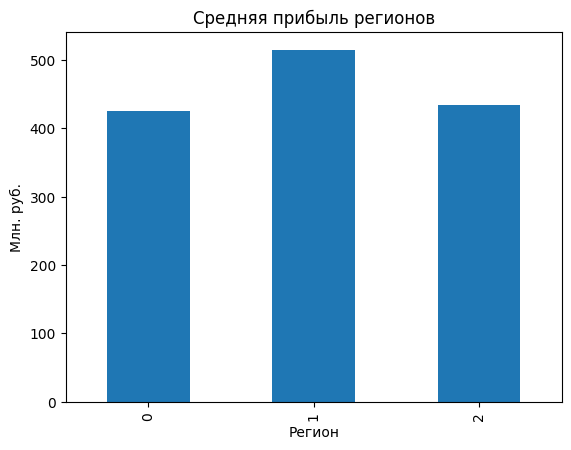

In [66]:
#Визуализируем средную прибыль для каждого из регионов
mean_income = pd.Series(mean_income)
mean_income.plot(kind='bar');
plt.title('Средняя прибыль регионов')
plt.xlabel('Регион')
plt.ylabel('Млн. руб.')

# Вывод

В рамках проекта был  проведен анализ добычи нефти в трех различных регионах для компании «ГлавРосГосНефть».Используя данные для каждой из имеющихся скважин, была создана модель, которая позволила предсказать регион с максимальной возможной прибылью.

Была создана модель, предсказывающая значения количества сырья в каждом из регионов со следующими средними значеними 
- для 0 - **92.6** тыс. бар.
- для 1 - **68.7** тыс. бар. 
- для 2 - **94.9** тыс. бар.

Был расчитан минимальный объем сырья, который необходим для безубыточной добычи. Он равен **111.1** тыс. бар. 

Для расчета возможной прибыли была применена технолгия bootstrap  и получены следующие результаты

Регион **0**

- Средняя прибыль для региона 0   **425938526** руб. 
- 95% доверительный интервал для региона 0   **-102090094 - 947976353**
- Риск убытков в процентах для региона 0   **6%**


Регион **1**

- Средняя прибыль для региона 1  **515222773** руб.
- 95% доверительный интервал для региона 1   **68873225 - 931547591**
- Риск убытков в процентах для региона 1   **1%**


Регион **2**

- Средняя прибыль для региона 2   **435008362** руб. 
- 95% доверительный интервал для региона 2   **-128880547 - 969706954**
- Риск убытков в процентах для региона 2   **6%**

На основе представленного анализа можно сделать вывод, что наиболее перспективным для добычи является **регион 1**. 